
#Fake Food Generation using GAN
##Installing Required libraries

Step 1.1- Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed. Please note that chapter has differnt Pytorch Lightning version and thus diff torch dependancies. Some functions may not work with other versions than what is tested below, so please ensure correct versions.


In [ ]:
!pip install pytorch-lightning==1.5.2 --quiet


In [ ]:
!pip install opendatasets --upgrade --quiet


In [ ]:
import opendatasets as od
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import torch
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from collections import OrderedDict
from torchvision.utils import save_image
import os

In [ ]:
print("matplotlib version:",matplotlib.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

matplotlib version: 3.2.2
torch version: 1.10.0+cu111
pytorch ligthening version: 1.5.2



#Step2- Download the dataset

Load the dataset- Please refer to the book in section "collecting the dataset" for the proper way to collect the dataset and steps to import it. Use your own ID to download the dataset


In [ ]:


#refer to the book for dataset location
#dataset_url =  ''


od.download(dataset_url)

In [ ]:
image_size = 64
batch_size = 128
normalize = [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
latent_size = 256

food_data_directory = "/content/food11-image-dataset/training"

In [ ]:
food_train_dataset = ImageFolder(food_data_directory, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalize)]))


food_train_dataloader = DataLoader(food_train_dataset, batch_size, num_workers=4, pin_memory=True, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denormalize(input_image_tensors):
    input_image_tensors = input_image_tensors * normalize[1][0]
    input_image_tensors = input_image_tensors + normalize[0][0]
    return input_image_tensors

In [ ]:
def display_images(images, total_images_to_display = 64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    images= images.detach()
    images = images[:total_images_to_display]
    denormalize_images = denormalize(images)

    ax.imshow(make_grid(denormalize_images, nrow=8).permute(1, 2, 0))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


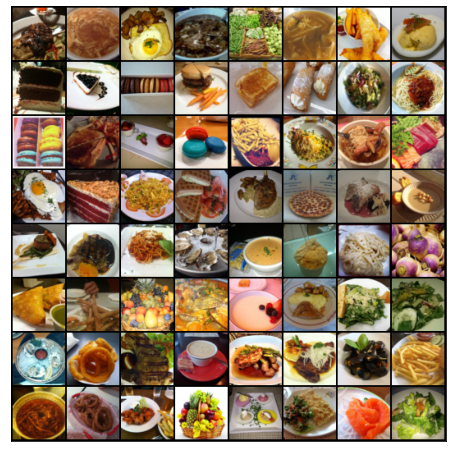

In [ ]:
for images, _ in food_train_dataloader:
  display_images(images)
  break

In [ ]:
def save_generated_samples(index, sample_images):
    fake_fname = 'generated-images-{}.png'.format(index)
    save_image(denormalize(sample_images[-64:]), os.path.join(".", fake_fname), nrow=8)

In [ ]:
class FoodDiscriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.input_size = input_size
        self.channel = 3
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.bias = False
        self.negative_slope = 0.2

        #input size: (3,64,64)
        self.conv1 = nn.Conv2d(self.channel, 128, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.LeakyReLU(self.negative_slope, inplace=True)

        #input size: (128,32,32)
        self.conv2 =  nn.Conv2d(128, 256, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn2 = nn.BatchNorm2d(256)

        #input size: (256,16,16)
        self.conv3 =  nn.Conv2d(256, 512, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn3 = nn.BatchNorm2d(512)

        #input size: (512,8,8)
        self.conv4 =  nn.Conv2d(512, 1024, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias)
        self.bn4 = nn.BatchNorm2d(1024)

        self.fc = nn.Sequential(
            nn.Linear(in_features=16384,out_features=1),
            nn.Sigmoid()
        )


    def forward(self, input_img):
        validity = self.conv1(input_img)
        validity = self.bn1(validity)
        validity = self.relu(validity)
        validity = self.conv2(validity)
        validity = self.bn2(validity)
        validity = self.relu(validity)
        validity = self.conv3(validity)
        validity = self.bn3(validity)
        validity = self.relu(validity)
        validity = self.conv4(validity)
        validity = self.bn4(validity)
        validity = self.relu(validity)
        validity=validity.view(-1, 1024*4*4)
        validity=self.fc(validity)
        return validity

In [ ]:
class FoodGenerator(nn.Module):
    def __init__(self, latent_size = 256):
        super().__init__()
        self.latent_size = latent_size
        self.kernel_size = 4
        self.stride = 2
        self.padding = 1
        self.bias = False

        self.model = nn.Sequential(

              #input size: (latent_size,1,1)
              nn.ConvTranspose2d(latent_size, 512, kernel_size=self.kernel_size, stride=1, padding=0, bias=self.bias),
              nn.BatchNorm2d(512),
              nn.ReLU(True),

              #input size: (512,4,4)
              nn.ConvTranspose2d(512, 256, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(256),
              nn.ReLU(True),

              #input size: (256,8,8)
              nn.ConvTranspose2d(256, 128, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(128),
              nn.ReLU(True),

              #input size: (128,16,16)
              nn.ConvTranspose2d(128, 64, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(64),
              nn.ReLU(True),

              nn.ConvTranspose2d(64, 3, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.Tanh()
              # output size: 3 x 64 x 64
        )

    def forward(self, input_img):
        input_img = self.model(input_img)
        return input_img

In [ ]:
ALL_FOOD_IMAGES = []
class FoodGAN(pl.LightningModule):

    def __init__(self, latent_size = 256,learning_rate = 0.0002,bias1 = 0.5,bias2 = 0.999,batch_size = 128):
        super().__init__()
        self.save_hyperparameters()

        # networks
        # data_shape = (channels, width, height)
        self.generator = FoodGenerator()
        self.discriminator = FoodDiscriminator(input_size=64)

        self.batch_size = batch_size
        self.latent_size = latent_size
        self.validation = torch.randn(self.batch_size, self.latent_size, 1, 1)

        # self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, preds, targets):
        return F.binary_cross_entropy(preds, targets)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_images, _ = batch

        # train generator
        if optimizer_idx == 0:

            # Generate fake images
            fake_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
            fake_random_noise = fake_random_noise.type_as(real_images)
            fake_images = self(fake_random_noise) #self.generator(latent)
            
            # Try to fool the discriminator
            preds = self.discriminator(fake_images)
            targets = torch.ones(self.batch_size, 1)
            targets = targets.type_as(real_images)
            
            loss = self.adversarial_loss(preds, targets)
            self.log('generator_loss', loss, prog_bar=True)

            tqdm_dict = {'g_loss': loss}
            output = OrderedDict({
                'loss': loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output


        # train discriminator
        if optimizer_idx == 1:

            # Pass real images through discriminator
            real_preds = self.discriminator(real_images)
            real_targets = torch.ones(real_images.size(0), 1)
            real_targets = real_targets.type_as(real_images)
            real_loss = self.adversarial_loss(real_preds, real_targets)
            # real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            real_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
            real_random_noise = real_random_noise.type_as(real_images)
            fake_images = self(real_random_noise) #self.generator(latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1)
            fake_targets = fake_targets.type_as(real_images)
            fake_preds = self.discriminator(fake_images)
            fake_loss = self.adversarial_loss(fake_preds, fake_targets)
            # fake_score = torch.mean(fake_preds).item()
            self.log('discriminator_loss', fake_loss, prog_bar=True)

            # Update discriminator weights
            loss = real_loss + fake_loss
            self.log('total_loss', loss, prog_bar=True)
            #########
            tqdm_dict = {'d_loss': loss}
            output = OrderedDict({
                'loss': loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output

    def configure_optimizers(self):
        learning_rate = self.hparams.learning_rate
        bias1 = self.hparams.bias1
        bias2 = self.hparams.bias2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(bias1, bias2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=(bias1, bias2))
    
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # import pdb;pdb.set_trace()
        z = self.validation.type_as(self.generator.model[0].weight)
        sample_imgs = self(z) #self.current_epoch
        ALL_FOOD_IMAGES.append(sample_imgs.cpu())
        save_generated_samples(self.current_epoch, sample_imgs)

In [ ]:
%%time
model = FoodGAN()
trainer = pl.Trainer( max_epochs=100, progress_bar_refresh_rate=25, gpus=1)#gpus=1,
trainer.fit(model, food_train_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=25)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | generator     | FoodGenerator     | 4.9 M 
1 | discriminator | FoodDiscriminator | 11.0 M
----------------------------------------------------
15.9 M    Trainable params
0         Non-

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'log', 'progress_bar'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


CPU times: user 14min 36s, sys: 1min 35s, total: 16min 12s
Wall time: 2h 3min 20s


In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

In [ ]:
! ls lightning_logs


version_0


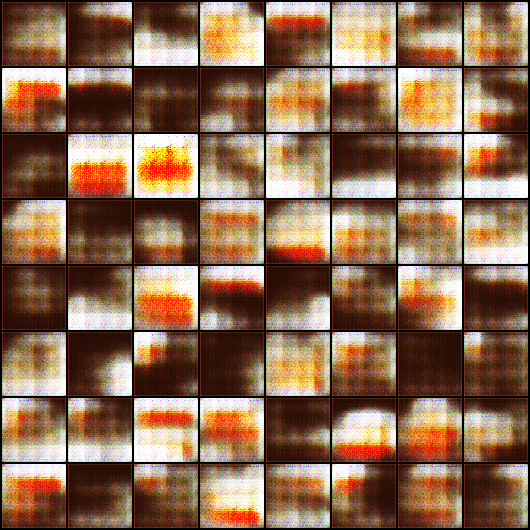

In [ ]:
from IPython.display import Image
Image('./generated-images-1.png')

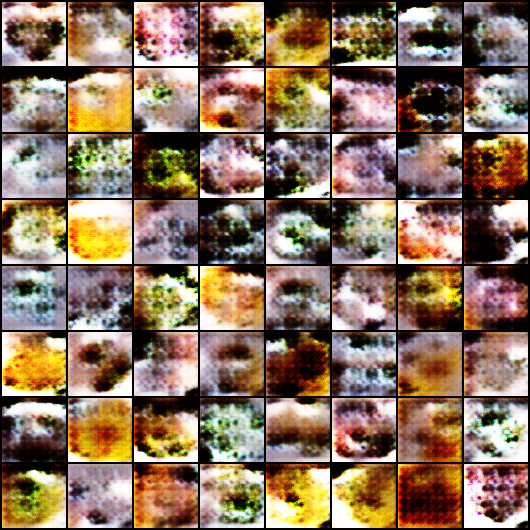

In [ ]:
from IPython.display import Image
Image('./generated-images-9.png')

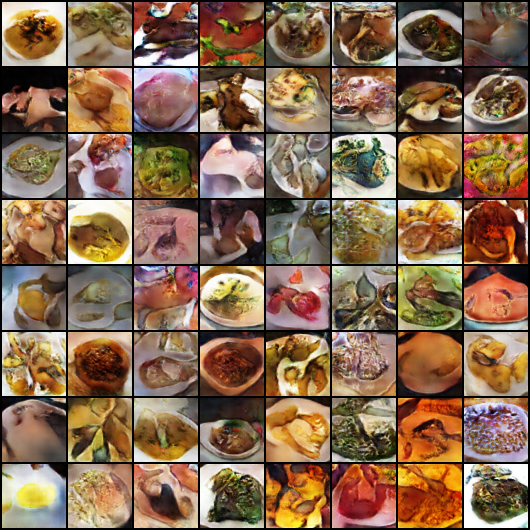

In [ ]:
from IPython.display import Image
Image('./generated-images-99.png')